## Simulator

In [36]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
#import lightning as L 
import pytorch_lightning as pl

import torch
DEVICE = 'GPU'
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100


class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise

100%|██████████| 1000/1000 [00:00<00:00, 2844.08it/s]


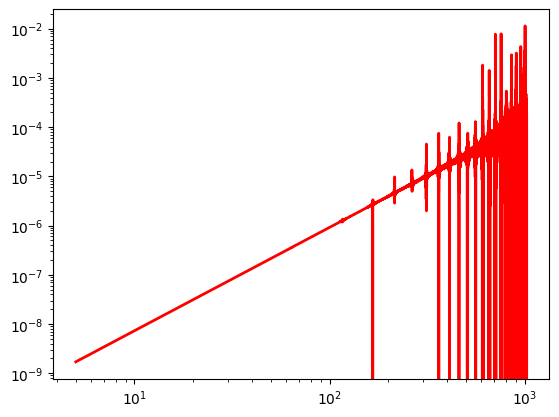

In [37]:
fref = 25
CE_PSD = np.genfromtxt("cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100000) # 100,000 samples
#for i in range(len(samples)):
#    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

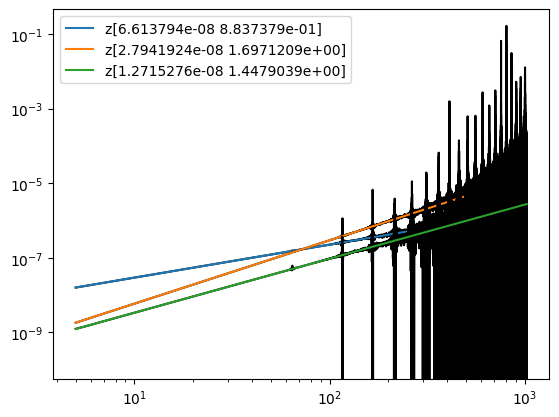

In [40]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

In [41]:
samples['x'].shape

(1000, 4076)

In [137]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
    
# Define UNet

class UNet_Deep(nn.Module):
    def __init__(self):
        super(UNet_Deep, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, padding=4),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [98]:
# Deep Net Summary
from torchsummary import summary
model = UNet_Deep()
summary(model, input_size=(1, 4076))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 4076]              64
              ReLU-2             [-1, 16, 4076]               0
         MaxPool1d-3             [-1, 16, 2038]               0
            Conv1d-4             [-1, 32, 2038]           1,568
              ReLU-5             [-1, 32, 2038]               0
         MaxPool1d-6             [-1, 32, 1019]               0
            Conv1d-7             [-1, 64, 1019]           6,208
              ReLU-8             [-1, 64, 1019]               0
         MaxPool1d-9              [-1, 64, 509]               0
           Conv1d-10             [-1, 128, 509]          24,704
             ReLU-11             [-1, 128, 509]               0
        MaxPool1d-12             [-1, 128, 254]               0
           Conv1d-13             [-1, 256, 254]          98,560
             ReLU-14             [-1, 2

In [146]:
# Pre-Process Data

import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

x_samples = samples['x']
m_samples = samples['m']

scaler = StandardScaler()
#scaler = MinMaxScaler()

x_scaled = scaler.fit_transform(x_samples)
m_scaled = scaler.fit_transform(m_samples)

x_train, x_test, m_train, m_test = train_test_split(x_scaled, m_scaled, test_size=0.1)



In [149]:
from torch.utils.data import TensorDataset

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
m_train_tensor = torch.tensor(m_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_test, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [150]:

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Add channel dimension
        loss = criterion(outputs, targets.unsqueeze(1))  # Add channel dimension
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation
model.eval()

Epoch [1/10], Loss: 0.0158
Epoch [2/10], Loss: 0.0158
Epoch [3/10], Loss: 0.0158
Epoch [4/10], Loss: 0.0158
Epoch [5/10], Loss: 0.0158
Epoch [6/10], Loss: 0.0158
Epoch [7/10], Loss: 0.0158
Epoch [8/10], Loss: 0.0158
Epoch [9/10], Loss: 0.0158
Epoch [10/10], Loss: 0.0158


UNet_Deep(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): ReLU()
    (17): MaxPool1d(ker

In [151]:
# Evaluation on test set

model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.unsqueeze(1))  # Add channel dimension
        test_loss += criterion(outputs, targets.unsqueeze(1)).item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0210


## Try a Shallower Network

In [ ]:

# Define UNet

class UNet_Shallow(nn.Module):
    def __init__(self):
        super(UNet_Deep, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, padding=4),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



model = UNet_Shallow()
summary(model, input_size=(1, 4076))